In [238]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import FileLink

In [239]:
obstacle_clr = [255,0,0]
road_clr = [128,64,128]
road_clr_con = (0,255,0)

In [240]:
#Load image and gt

#TODO hardcoded paths

original_image_path = 'data/export/datasets/RoadAnomaly/test/imgs/animals27_wildlife_bear.png'
original_image = cv.imread(original_image_path) 
assert original_image is not None, "original_gt could not be read, check with os.path.exists()"

original_gt_path = 'data/export/datasets/RoadAnomaly/test/gt/animals27_wildlife_bear.png'
original_gt = cv.imread(original_gt_path) 
assert original_gt is not None, "original_image could not be read, check with os.path.exists()"


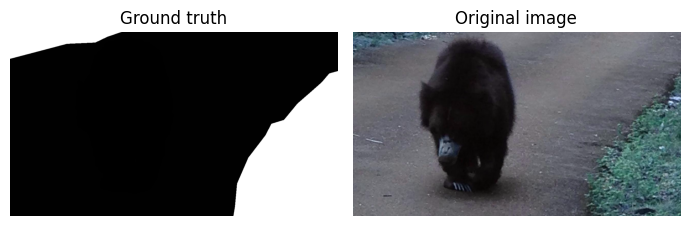

In [241]:
#Image preview

fig, ax = plt.subplots(1, 2, figsize=(7, 3))  # 1 row, 2 columns, and adjust the figure size as needed
# Display the mask
ax[0].imshow(original_gt)
ax[0].set_title('Ground truth')
ax[0].axis('off')  # Hide axes

# Display the image
ax[1].imshow(original_image)
ax[1].set_title('Original image')
ax[1].axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

In [242]:
# Overlay of gt with image
def drawOverlay(opacity):
    assert original_image.shape[:2] == original_gt.shape[:2], "Images must have the same dimensions"

    # Create masks of gt
    road_mask = (original_gt == 1)
    obstacle_mask = (original_gt == 0)

    # Create a road and anomaly overlays with the same size as the image
    road_overlay = np.zeros_like(original_image)
    road_overlay[:, :] = road_clr

    obstacle_overlay = np.zeros_like(original_image)
    obstacle_overlay[:, :] = obstacle_clr


    #Create colored masks
    road_clr_mask = road_overlay * road_mask
    obstacle_clr_mask = obstacle_overlay * obstacle_mask
    combined_mask = cv.add(road_clr_mask, obstacle_clr_mask)

    if(opacity != 1):
        combined_image = cv.addWeighted(combined_mask, opacity, original_image , 1, 0)
    else:    
        inverted_mask = np.where(combined_mask == 0, 1, 0).astype(np.uint8)
        combined_image = cv.add(combined_mask, inverted_mask * original_image)
    return combined_image

    fig, ax = plt.subplots(1, 4, figsize=(10, 6))
    ax[0].imshow(original_image)
    ax[0].set_title('Original_image')
    ax[0].axis('off') 

    ax[1].imshow(road_clr_mask)
    ax[1].set_title('Colored mask')
    ax[1].axis('off')  

    ax[2].imshow(combined_mask)
    ax[2].set_title('Combined mask')
    ax[2].axis('off')  

    ax[3].imshow(combined_image)
    ax[3].set_title('Combined image')
    ax[3].axis('off')  

    plt.tight_layout()
    plt.show()

In [243]:
def drawContoure():
    thickness = 3

    # Convert image to grayscale
    imgray = cv.cvtColor(original_gt, cv.COLOR_BGR2GRAY)

    # Apply thresholding
    _, road_thresh = cv.threshold(imgray, 1, 255, 0)
    _, obstacle_thresh = cv.threshold(imgray, 0, 255, 0)

    # FindContours 
    road_contours, _ = cv.findContours(road_thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    obstacle_contours, _ = cv.findContours(obstacle_thresh, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    
    # Draw the contours on the original image (or a copy of it)
    contours_image = original_image.copy()
    cv.drawContours(contours_image, road_contours, -1, road_clr_con, thickness)  
    cv.drawContours(contours_image, obstacle_contours, -1, obstacle_clr , thickness)  

    return contours_image

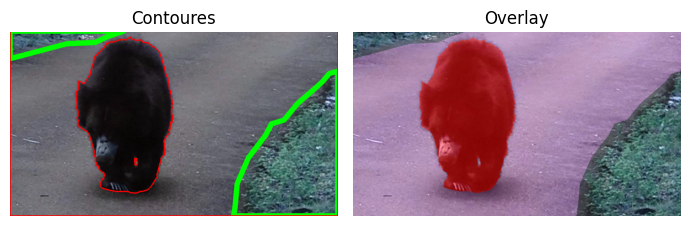

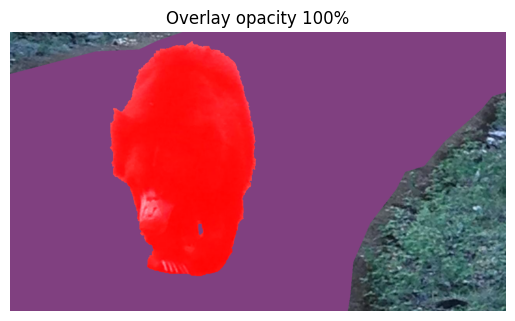

In [244]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))  # 1 row, 2 columns, and adjust the figure size as needed
ax[0].imshow(drawContoure())
ax[0].set_title('Contoures')
ax[0].axis('off') 

ax[1].imshow(drawOverlay(0.5))
ax[1].set_title('Overlay')
ax[1].axis('off')  
plt.tight_layout()
plt.show()



plt.imshow(drawOverlay(1))
plt.title("Overlay opacity 100%")
plt.axis('off')
plt.show()

